# ak-energy-data Data Updating Administrative Tasks

This notebook is used to update and maintain the data on the ak-energy-data.analysisnorth.com site.  The data on that site is arranged in a hierarchical directory structure; top-level directories indicate the general type of data, e.g. `wx` (weather) and `city-util` (city and utility).  Sub-directories may be present to further categorize data.  Generally at the bottom level of the directory structure are two folders: `raw` and `proc`.  The `raw` folder holds the unprocessed source data, like an unprocessed TMY3 file.  The `proc` folder holds data that has been processed and transformed from the `raw` folder.

That directory structure is mirrored in the `data` directory of this GitHub repo.  This notebook operates on that local data. The general approach to updating the data is to update the raw source data in your local GitHub repo and then run the relevant sections of code below to produce the processed data.  Once you are satisfied with the results, the final code in each section below allows you to upload the new data to the live site.


**NOTE:** The live site is stored on an Amazon Web Services (AWS) S3 bucket configured for static web site hosting. Updating that data requires AWS permissions that allow updating
the `ak-energy-data.analysisnorth.com` S3 bucket.  It also requires that the `boto3` Python is installed, which allows for manipulation of AWS S3 data.

In [1]:
# Execute this cell prior to any of the cells below
import os
from glob import glob
from datetime import datetime
import importlib
import csv
import io
import math
import pandas as pd
import numpy as np
from fuzzywuzzy import process, fuzz
import admin_util as au  # a utility library in this repo.
#importlib.reload(au)    # needed if you modify the admin_util library

from matplotlib.pyplot import *
# Show Plots in the Notebook
%matplotlib inline

bucket = au.Bucket('ak-energy-data.analysisnorth.com')

C:\Users\Alan\Anaconda2\envs\py37\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
rcParams['figure.figsize']= (9, 5)   # set Chart Size
rcParams['font.size'] = 14            # set Font size in Chart

## Upload Index Notebook to the Site

Do this if you have changed anything in the index.ipynb notebook and want to update the live site with it.

In [103]:
# Convert notebook to HTML
!jupyter nbconvert index.ipynb --to html

# Upload the HTML
bucket.upload_file('index.html', 'index.html')

# Upload the Actual Notebook
bucket.upload_file('index.ipynb', 'index.ipynb')

[NbConvertApp] Converting notebook index.ipynb to html
[NbConvertApp] Writing 312996 bytes to index.html


uploaded index.html with Content Type: text/html
uploaded index.ipynb with Content Type: application/octet-stream


## Upload and Process AkWarm Library Files

**NOTE:** This step relies upon the TMY3 climate files so if you intend to
change those files, do that first. See the susbsequent section on 
TMY3 processing, if needed.

In [3]:
# Clear out the proc directory
au.clear_dir('data/city-util/proc')

deleting data/city-util/proc\city.csv
deleting data/city-util/proc\city.pkl
deleting data/city-util/proc\misc_info.csv
deleting data/city-util/proc\misc_info.pkl
deleting data/city-util/proc\utility.csv
deleting data/city-util/proc\utility.pkl


Edit the following 4 AkWarm Library files, exported to Excel format, in the `data/city-util/raw` directory:

    City.xlsx
    City Utility Links.xlsx
    Utility.xlsx
    Misc Info.xlsx

In [4]:
# Some functions needed for processing

def haversine(lat1, lon1, lat2, lon2):
    """Calculate the great circle distance between a point on earth
    and an array of other points.  Lat/Lon in decimal degrees.
    lat1 & lon1 are the single point, lat2 and lon2 are numpy
    arrays.
    """
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2. * np.arcsin(np.sqrt(a))
    km = 6367. * c
    return km

def closest_tmy(city_ser, dft):
    """Finds the closest TMY3 site, and returns ID and City, State name of
    that TMY3 site.  'city_ser' is a Pandas Series describing the city, and 'dft'
    is a DataFrame of meta data describing the possible TMY sites. 
    """
    dists = haversine(city_ser.Latitude, city_ser.Longitude, dft.latitude, dft.longitude)
    closest_id = dists.idxmin()
    tmy_site = dft.loc[closest_id]
    return closest_id, '{}, {}'.format(tmy_site.city, tmy_site.state)


In [21]:
# read in the DataFrame that describes the available TMY3 climate files.
df_tmy_meta = pd.read_pickle('data/wx/tmy3/proc/tmy3_meta.pkl', compression='bz2')

# Read in the other City and Utility Excel files.
df_city = pd.read_excel('data/city-util/raw/City.xlsx')
df_city_util_link = pd.read_excel('data/city-util/raw/City Utility Links.xlsx')

# Retrieve the Miscellaneous Information and store into a Pandas Series.
misc_info = pd.read_excel('data/city-util/raw/Misc Info.xlsx').iloc[0]

df_util = pd.read_excel('data/city-util/raw/Utility.xlsx')
df_util.drop(['SiteSourceMultiplierOverride', 'BuybackRate', 'Notes'], axis=1, inplace=True)
df_util.index = df_util.ID
df_util['NameShort'] = df_util['Name'].str[:6]

# make a list of blocks with rates for each utility and save that as
# a column in the DataFrame.
blocks_col = []
for ix, util in df_util.iterrows():
    adjust = au.chg_nonnum(util.FuelSurcharge, 0.0) + au.chg_nonnum(util.PurchasedEnergyAdj, 0.0)
    if util.ChargesRCC:
        adjust += au.chg_nonnum(misc_info.RegSurchargeElectric, 0.0)
    blocks = []
    for blk in range(1, 6):
        block_kwh = au.chg_nonnum(util['Block{}'.format(blk)], math.nan)
        block_rate = au.chg_nonnum(util['Rate{}'.format(blk)], math.nan)
        if not math.isnan(block_rate):
            block_rate += adjust
        blocks.append((block_kwh, block_rate))
    blocks_col.append(blocks)
df_util['Blocks'] = blocks_col

df_city = df_city.query('Active == 1')[[
    'ID',
    'Name',
    'Latitude',
    'Longitude',
    'ERHRegionID',
    'WAPRegionID',
    'ImpCost',
    'FuelRefer',
    'FuelCityID',
    'Oil1Price',
    'Oil2Price',
    'PropanePrice',
    'BirchPrice',
    'SprucePrice',
    'CoalPrice',
    'SteamPrice',
    'HotWaterPrice',
    'MunicipalSalesTax',
    'BoroughSalesTax'
]]
df_city.set_index('ID', inplace=True)

# Find the closest TMY3 site to each city.
# Find the Electric Utilities associated with each city.
# Determine a Natural Gas price for the city if there is 
# a natural gas utility present.
# Put all this information in the City DataFrame.
tmy_ids = []
tmy_names = []
utils = []
gas_prices = []
SELF_GEN_ID = 131   # ID number of "Self-Generation" utility
for ix, city_ser in df_city.iterrows():
    
    # get closest TMY3 site
    id, nm = closest_tmy(city_ser, df_tmy_meta)    
    tmy_ids.append(id)
    tmy_names.append(nm)
    
    # find electric utilities associated with city
    util_list = df_city_util_link.query('CityID == @ix')['UtilityID']
    df_city_utils = df_util.loc[util_list]
    elec_utils = df_city_utils.query('Type==1 and Active==1').copy()
    elec_utils.sort_values(by=['NameShort', 'IsCommercial', 'ID'], inplace=True)
    if len(elec_utils) > 0:
        utils.append(list(zip(elec_utils.Name, elec_utils.ID)))
    else:
        # If there is no Electric Utility associated with this city,
        # assign the self-generation electric utility.
        utils.append([('Self Generation', SELF_GEN_ID)])

    # In AkWarm, there is only PCE data for the residential rate structures.
    # We need to add it to the Commercial rate structures becuase community
    # building may use those rates, and they potentially can get PCE.  So,
    # For each city, look at the utilities and find the PCE value.  Then
    # use that for the rate structures that are missing a PCE value.
    # This code wouldn't work if there were multiple utilities serving a city
    # with different PCE rates.  But that only occurs in the Anchorage area,
    # and there is no PCE there.
    pce_val = elec_utils.PCE.max()
    if pce_val > 0.0:
        for ix, util in elec_utils.iterrows():
            if math.isnan(util.PCE):
                df_util.loc[ix, 'PCE'] = pce_val

    # if there is a gas utility, determine the marginal gas price
    # at a usage of 130 ccf/month, and assign that to the City.
    # This avoids the complication of working with the block rate
    # structure.
    gas_price = math.nan
    gas_utils = df_city_utils.query('Type==2 and Active==1').copy()
    # Use a residential gas utility, the smallest ID
    if len(gas_utils):
        gas_util = gas_utils.sort_values(by=['IsCommercial', 'ID']).iloc[0]
        # get the rate for a usage of 130 ccf
        for block in range(1, 6):
            block_val = gas_util['Block{}'.format(block)]
            #set_trace()
            if math.isnan(block_val) or block_val >= 130:
                gas_price = gas_util['Rate{}'.format(block)] + \
                            au.chg_nonnum(gas_util.FuelSurcharge, 0.0) + \
                            au.chg_nonnum(gas_util.PurchasedEnergyAdj, 0.0)
                break

    gas_prices.append(gas_price)


# Put all the information determined above for the cities into the
# City DataFrame as new columns.
df_city['TMYid'] = tmy_ids
df_city['TMYname'] = tmy_names
df_city['ElecUtilities'] = utils
df_city['GasPrice'] =  gas_prices

# delete out the individual block and rate columns in the utility table,
# and surcharges, as they are no longer needed.
df_util.drop(['Block{}'.format(n) for n in range(1, 6)], axis=1, inplace=True)
df_util.drop(['Rate{}'.format(n) for n in range(1, 6)], axis=1, inplace=True)
df_util.drop(['PurchasedEnergyAdj', 'FuelSurcharge'], axis=1, inplace=True)

# Also have to look to see if a city relies on another city
# for its fuel prices
for ix, cty in df_city.query('FuelRefer > 0').iterrows():
    # get the city referred to
    cty_fuel = df_city.loc[int(cty.FuelCityID)]
    # Transfer over fuel prices
    for c in df_city.columns:
        if c.endswith('Price'):
            df_city.loc[ix, c] = cty_fuel[c]
            

C:\Users\Alan\Anaconda2\envs\py37\lib\site-packages\ipykernel_launcher.py:77: FutureWarning: 'ID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\Alan\Anaconda2\envs\py37\lib\site-packages\ipykernel_launcher.py:107: FutureWarning: 'ID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


#### Link Cities to Census Areas and Other Geographic Areas

Also, determine typical monthly residential consumption for each city.

In [22]:
# read in the data linking ARIS cities to Census Areas
df_city_to_census = pd.read_csv('other_data/aris_city_to_census_lookups.csv')

# convert Hub column to boolean
df_city_to_census['Hub'] = df_city_to_census.Hub.astype('bool')

# rename some columns
df_city_to_census.rename(columns={'Hub': 'hub', 'ARIS_cities': 'aris_city'}, inplace=True)

df_city_to_census.head()

,aris_city,census_city,census_area,ancsa_region,railbelt,hub
0,Akutan,Akutan city,Aleutians East Borough,Aleut,Affordable Energy Strategy Area,False
1,Cold Bay,Cold Bay city,Aleutians East Borough,Aleut,Affordable Energy Strategy Area,False
2,False Pass,False Pass city,Aleutians East Borough,Aleut,Affordable Energy Strategy Area,False
3,King Cove,King Cove city,Aleutians East Borough,Aleut,Affordable Energy Strategy Area,False
4,Nelson Lagoon,Nelson Lagoon CDP,Aleutians East Borough,Aleut,Affordable Energy Strategy Area,False


In [23]:
# For each city in the main City DataFrame, find the matching ARIS city (using
# fuzzy matching) and add a column for that

aris_cities = df_city_to_census.aris_city.values
matching_cities = []
for akw_cty in df_city.Name:
    mtch_cty, ratio = process.extractOne(akw_cty, aris_cities)
    if ratio >= 90:
        matching_cities.append(mtch_cty)
    else:
        print(f'Closest match for {akw_cty} is {mtch_cty} ({ratio}). Add a better match to aris_city_to_census_lookups.csv.')
        matching_cities.append('')

df_city['aris_city'] = matching_cities
df_city[['Name', 'aris_city']].head()

,Name,aris_city
ID,,
1,Anchorage,Anchorage
2,Adak,Adak
3,Akutan,Akutan
4,Allakaket,Allakaket
5,Angoon,Angoon


In [24]:
# Merge in the Census & Geographic area data
print(len(df_city))
# Need to do the merge this way in order to preserve the Left index
df_city = df_city.join(df_city_to_census.set_index('aris_city'), how='left', on='aris_city')
print(len(df_city))
df_city.iloc[0]

274
274


Name                                                         Anchorage
Latitude                                                        61.152
Longitude                                                     -149.864
ERHRegionID                                                          2
WAPRegionID                                                          2
ImpCost                                                              1
FuelRefer                                                        False
FuelCityID                                                         NaN
Oil1Price                                                         3.08
Oil2Price                                                          NaN
PropanePrice                                                       4.5
BirchPrice                                                         325
SprucePrice                                                        345
CoalPrice                                                          175
SteamP

In [25]:
# read in the data that links Hub cities and Census Areas non-hub cities to 
# average residential use per month.
df_avg_use = pd.read_csv('other_data/monthly_average_kwh_per_res_customer_by_census_area_and_hub.csv')

# Rename some columns
df_avg_use.rename(columns={'Census Area': 'census_area', 'City': 'city'}, inplace=True)

# Make a column with the monthly values as a list, also calc average of the months
uses = []
ann_avg = []
for ix, row in df_avg_use.iterrows():
    mo_uses = [row[str(i)] for i in range(1, 13)]
    avg_use = sum(mo_uses) / 12.0
    uses.append(mo_uses)
    ann_avg.append(avg_use)
df_avg_use['use_list'] = uses
df_avg_use['annual_avg'] = ann_avg
df_avg_use.head()

,census_area,city,1,2,3,4,5,6,7,8,9,10,11,12,use_list,annual_avg
0,Aleutians East Borough,non hub,500.991562,439.984316,456.510656,421.946347,426.966353,380.763389,392.608544,400.059090,410.119915,434.168675,445.715397,472.657556,"[500.99156233, 439.98431584599996, 456.5106555...",431.874317
1,Aleutians East Borough,sand point,483.801762,479.004112,429.684629,451.861062,394.841863,409.583381,398.601090,397.997461,407.677428,404.244337,452.281970,491.506478,"[483.801762115, 479.004111601, 429.684628975, ...",433.423798
2,Aleutians West Census Area,non hub,471.936998,423.455318,460.815493,424.294303,414.198262,408.021373,428.550250,419.713312,409.077785,425.893820,443.339960,463.328994,"[471.936998147, 423.45531781, 460.81549341, 42...",432.718822
3,Aleutians West Census Area,unalaska,663.296679,611.842084,589.155191,593.183520,513.669263,475.191489,481.951203,483.521810,487.777910,557.754717,553.457433,571.368331,"[663.296679369, 611.842083731, 589.155191257, ...",548.514136
4,Bethel Census Area,bethel,698.644894,584.884631,573.799682,512.091104,451.084172,433.770685,432.120950,442.711917,440.380026,493.366013,521.677916,619.730219,"[698.6448943930001, 584.884631169, 573.7996821...",517.021851


In [26]:
# Determine a monthly profile to be used by cities that are not covered.
# Because the above data came from PCE, non-covered cities are primarily Urban.
# Take the average of the Hub cities that have annual usages > 500 kWh/month
df_hubs = df_avg_use.query('city != "non hub"').copy()
df_lg_hubs = df_hubs.query('annual_avg > 500')
df_lg_hubs

,census_area,city,1,2,3,4,5,6,7,8,9,10,11,12,use_list,annual_avg
3,Aleutians West Census Area,unalaska,663.296679,611.842084,589.155191,593.183520,513.669263,475.191489,481.951203,483.521810,487.777910,557.754717,553.457433,571.368331,"[663.296679369, 611.842083731, 589.155191257, ...",548.514136
4,Bethel Census Area,bethel,698.644894,584.884631,573.799682,512.091104,451.084172,433.770685,432.120950,442.711917,440.380026,493.366013,521.677916,619.730219,"[698.6448943930001, 584.884631169, 573.7996821...",517.021851
16,Northwest Arctic Borough,kotzebue,765.111630,722.148670,615.631722,627.924136,578.497409,524.268541,505.316332,539.603699,556.177166,589.277825,671.651241,669.153015,"[765.111630278, 722.148670461, 615.631722029, ...",613.730115
24,Valdez-Cordova Census Area,cordova,570.217240,547.299401,496.621477,504.917479,467.503786,466.190370,452.391331,468.486208,510.772508,490.943599,556.001154,580.845084,"[570.21724029, 547.299400568, 496.621477213000...",509.349136


In [27]:
# Average those cities together to get the default usage value.
means = df_lg_hubs.mean()
default_use = [means[str(i)] for i in range(1, 13)]
default_use

[674.3176110825001,
 616.54369648225,
 568.8020181537499,
 559.5290597065,
 502.68865773625,
 474.855271649,
 467.94495386925,
 483.58090842574995,
 498.77690241749997,
 532.8355384270001,
 575.696935941,
 610.274161992]

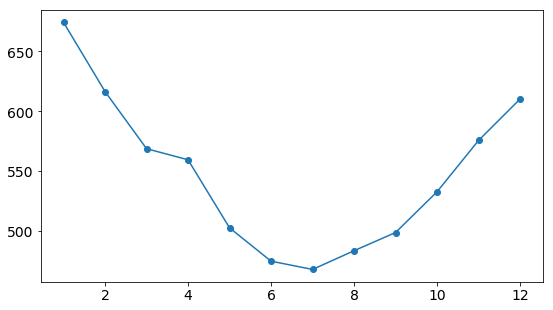

In [28]:
plot(range(1, 13), default_use, marker='o')

In [29]:
# Add the average use info as a list to the city DataFrame.

# get the list of hub cities that have average usage data
cities = set(df_avg_use.city) - {'non hub'}

# get the list of Census Areas that have non-hub average uses
census_areas = set(df_avg_use.query('city == "non hub"').census_area)

mo_usages = []
for ix, row in df_city.iterrows():
    city = row.Name
    c_area = row.census_area
    is_hub = row.hub
    
    # see if the city is a hub city in the list of cities with data
    if is_hub:
        mtch_cty, ratio = process.extractOne(city, cities)
        if ratio >= 90:
            rec = df_avg_use.query('city == @mtch_cty').iloc[0]
            usages = [rec[str(i)] for i in range(1, 13)]
            mo_usages.append(usages)
        else:
            mo_usages.append(default_use)
    else:
        # non-hub cities
        mtch_census, ratio = process.extractOne(c_area, census_areas)
        if ratio >= 90:
            rec = df_avg_use.query('census_area == @mtch_census and city == "non hub"').iloc[0]
            usages = [rec[str(i)] for i in range(1, 13)]
            mo_usages.append(usages)
        else:
            # No match for census area
            # These are probably cities in the Railbelt that aren't hub, or in SE.
            # So, they probably still have relatively high usage.
            mo_usages.append(default_use)
df_city['avg_elec_usage'] = mo_usages

In [30]:
df_city[['Name', 'census_area', 'avg_elec_usage']].head(10)

,Name,census_area,avg_elec_usage
ID,,,
1,Anchorage,Anchorage municipality,"[674.3176110825001, 616.54369648225, 568.80201..."
2,Adak,Aleutians West Census Area,"[471.936998147, 423.45531781, 460.81549341, 42..."
3,Akutan,Aleutians East Borough,"[500.99156233, 439.98431584599996, 456.5106555..."
4,Allakaket,Yukon-Koyukuk Census Area,"[338.509000744, 291.889556239, 276.804469551, ..."
5,Angoon,Hoonah-Angoon Census Area,"[277.08055898099997, 257.757954545, 237.155612..."
6,Aniak,Bethel Census Area,"[416.867554436, 363.900387399, 367.474233607, ..."
8,Arctic Village,Yukon-Koyukuk Census Area,"[338.509000744, 291.889556239, 276.804469551, ..."
9,Atka,Aleutians West Census Area,"[471.936998147, 423.45531781, 460.81549341, 42..."
11,Auke Bay,Juneau City and Borough,"[674.3176110825001, 616.54369648225, 568.80201..."


#### Save the DataFrames

In [31]:
# Save the created DataFrames
au.save_df(df_city, 'data/city-util/proc/city')
au.save_df(df_util, 'data/city-util/proc/utility')
au.save_df(misc_info, 'data/city-util/proc/misc_info')  # this routine works with Pandas Series as well

saving DataFrame to data/city-util/proc/city.pkl and .csv
saving DataFrame to data/city-util/proc/utility.pkl and .csv
saving DataFrame to data/city-util/proc/misc_info.pkl and .csv


In [32]:
# Check the data
pd.read_pickle('data/city-util/proc/city.pkl', compression='bz2').head()

,Name,Latitude,Longitude,ERHRegionID,WAPRegionID,ImpCost,FuelRefer,FuelCityID,Oil1Price,Oil2Price,...,TMYname,ElecUtilities,GasPrice,aris_city,census_city,census_area,ancsa_region,railbelt,hub,avg_elec_usage
ID,,,,,,,,,,,,,,,,,,,,,
1,Anchorage,61.151958,-149.864105,2,2,1,False,NaN,3.08,NaN,...,"ANCHORAGE INTL AP, AK","[(Anchorage ML&P - Residential, 2), (Anchorage...",0.93955,Anchorage,Anchorage municipality,Anchorage municipality,Cook Inlet Regional (CIRI),Railbelt,True,"[674.3176110825001, 616.54369648225, 568.80201..."
2,Adak,51.848896,-176.635422,2,3,5,False,NaN,4.42,4.69,...,"ADAK NAS, AK","[(Adak -TDX Residential, 677), (Adak - TDX Com...",NaN,Adak,Adak city,Aleutians West Census Area,Aleut,Affordable Energy Strategy Area,False,"[471.936998147, 423.45531781, 460.81549341, 42..."
3,Akutan,54.134945,-165.772446,2,3,5,False,NaN,2.91,2.91,...,"DUTCH HARBOR, AK","[(Akutan, City of - Residential, 9), (Akutan, ...",NaN,Akutan,Akutan city,Aleutians East Borough,Aleut,Affordable Energy Strategy Area,False,"[500.99156233, 439.98431584599996, 456.5106555..."
4,Allakaket,66.561386,-152.649445,4,4,5,False,NaN,5.50,NaN,...,"BETTLES FIELD, AK","[(Allakaket - APT - Residential, 249), (Allaka...",NaN,Allakaket,Allakaket city,Yukon-Koyukuk Census Area,Doyon,Affordable Energy Strategy Area,False,"[338.509000744, 291.889556239, 276.804469551, ..."
5,Angoon,57.496647,-134.578903,1,1,3,False,NaN,4.10,4.08,...,"SITKA JAPONSKI AP, AK","[(Inside Passage Electric Coop - Residential, ...",NaN,Angoon,Angoon city,Hoonah-Angoon Census Area,Sealaska Corporation,Affordable Energy Strategy Area,False,"[277.08055898099997, 257.757954545, 237.155612..."


In [33]:
pd.read_pickle('data/city-util/proc/utility.pkl', compression='bz2').head()

,ID,Name,Active,Type,IsCommercial,ChargesRCC,PCE,CO2,CustomerChg,DemandCharge,NameShort,Blocks
ID,,,,,,,,,,,,
1,1,Chugach Electric- Residential,True,1,False,True,0.0000,1.10,8.00,NaN,Chugac,"[(nan, 0.18715799739584343), (nan, nan), (nan,..."
2,2,Anchorage ML&P - Residential,True,1,False,True,NaN,1.10,13.62,NaN,Anchor,"[(nan, 0.17457800125703232), (nan, nan), (nan,..."
3,3,Golden Valley Electric - Residential,True,1,False,True,NaN,2.28,17.50,NaN,Golden,"[(nan, 0.22799800289794792), (nan, nan), (nan,..."
5,5,Enstar Natural Gas - G1 (Res),True,2,False,True,0.0000,NaN,16.00,NaN,Enstar,"[(nan, 0.9405279974453149), (nan, nan), (nan, ..."
6,6,"Akhiok, City of Residential",True,1,False,False,0.3265,2.20,NaN,NaN,Akhiok,"[(nan, 0.800000011920929), (nan, nan), (nan, n..."


In [34]:
pd.read_pickle('data/city-util/proc/misc_info.pkl', compression='bz2')

ID                                                                      1
LibVersion                                            2018-09-27 00:00:00
DiscountRate                                                         0.03
RegSurcharge                                                        0.004
RegSurchargeElectric                                             0.000978
PCEkWhLimit                                                           500
PCEFundingPct                                                           1
MiscNotes               Inflation factors and discount rate from 2011 ...
Name: 0, dtype: object

In [35]:
# Upload the raw Excel files exported from AkWarm Library.
bucket.upload_dir('data/city-util/raw', 'city-util/raw', clear_dest_dir=True)

deleting city-util/raw/City Utility Links.xlsx
deleting city-util/raw/City.xlsx
deleting city-util/raw/Misc Info.xlsx
deleting city-util/raw/Utility.xlsx
uploaded data/city-util/raw\City Utility Links.xlsx with Content Type: application/vnd.openxmlformats-officedocument.spreadsheetml.sheet
uploaded data/city-util/raw\City.xlsx with Content Type: application/vnd.openxmlformats-officedocument.spreadsheetml.sheet
uploaded data/city-util/raw\Misc Info.xlsx with Content Type: application/vnd.openxmlformats-officedocument.spreadsheetml.sheet
uploaded data/city-util/raw\Utility.xlsx with Content Type: application/vnd.openxmlformats-officedocument.spreadsheetml.sheet


In [36]:
# Upload the processed files
bucket.upload_dir('data/city-util/proc', 'city-util/proc', clear_dest_dir=True)

deleting city-util/proc/city.csv
deleting city-util/proc/city.pkl
deleting city-util/proc/misc_info.csv
deleting city-util/proc/misc_info.pkl
deleting city-util/proc/utility.csv
deleting city-util/proc/utility.pkl
uploaded data/city-util/proc\city.csv with Content Type: text/csv
uploaded data/city-util/proc\city.pkl with Content Type: application/octet-stream
uploaded data/city-util/proc\misc_info.csv with Content Type: text/csv
uploaded data/city-util/proc\misc_info.pkl with Content Type: application/octet-stream
uploaded data/city-util/proc\utility.csv with Content Type: text/csv
uploaded data/city-util/proc\utility.pkl with Content Type: application/octet-stream


## Upload and Process TMY3 Files

Make sure all of the TMY3 files are in the `data/wx/tmy3/raw` directory.

In [31]:
# Create abbreviated TMY3 data in Pandas DataFrame and CSV files.
# accumulates metadata for each TMY3 file
au.clear_dir('data/wx/tmy3/proc/')

meta_list = []

for fn in glob('data/wx/tmy3/raw/*.csv'):
    
    # Use a csvreader just to process the header row
    with open(fn) as csvfile:                    
        tmyreader = csv.reader(csvfile)
        hdr = next(tmyreader)
        meta = dict(
            tmy_id = int(hdr[0]),
            city = hdr[1].strip(),
            state = hdr[2].strip(),
            utc_offset = float(hdr[3]),
            latitude = float(hdr[4]),
            longitude = float(hdr[5]),
            elevation = float(hdr[6]) * 3.28084   # in feet
        )

        # read the rest of the lines into a DataFrame
        df = pd.read_csv(csvfile)

        # start making final DataFrame
        df['db_temp'] = df['Dry-bulb (C)'] * 1.8 + 32.0   # deg F
        df['rh'] = df['RHum (%)']                         # 0 - 100
        df['wind_spd'] = df['Wspd (m/s)'] * 2.23694     # miles per hour
        df_final = df[['db_temp', 'rh', 'wind_spd']].copy()

        # make a list of date/times with the stamp occurring in the
        # middle of the hour associated with the data.  Also, use 
        # the year 2018 for all the timestamps
        ts = []
        for dt, tm in zip(df['Date (MM/DD/YYYY)'], df['Time (HH:MM)']):
            m, d, _ = dt.split('/')
            h, _ = tm.split(':')
            ts.append( datetime(2018, int(m), int(d), int(h) - 1, 30))

        df_final.index = ts
        df_final.index.name = 'timestamp'
        df_final['month'] = df_final.index.month

        meta['db_temp_avg'] = df_final.db_temp.mean()
        meta['rh_avg'] = df_final.rh.mean()
        meta['wind_spd_avg'] = df_final.wind_spd.mean()

        base_file = os.path.basename(fn)
        base_no_ext = base_file.split('.')[0]
        meta['url'] = f'http://ak-energy-data.analysisnorth.com/wx/tmy3/proc/{base_no_ext}'

        meta_list.append(meta)

        # --- Store the site's DataFrame
        au.save_df(df_final, f'data/wx/tmy3/proc/{base_no_ext}')

df_meta = pd.DataFrame(meta_list)
df_meta.set_index('tmy_id', inplace=True)
au.save_df(df_meta, f'data/wx/tmy3/proc/tmy3_meta')

deleting data/wx/tmy3/proc\700197.csv
deleting data/wx/tmy3/proc\700197.pkl
deleting data/wx/tmy3/proc\700260.csv
deleting data/wx/tmy3/proc\700260.pkl
deleting data/wx/tmy3/proc\700637.csv
deleting data/wx/tmy3/proc\700637.pkl
deleting data/wx/tmy3/proc\701043.csv
deleting data/wx/tmy3/proc\701043.pkl
deleting data/wx/tmy3/proc\701195.csv
deleting data/wx/tmy3/proc\701195.pkl
deleting data/wx/tmy3/proc\701330.csv
deleting data/wx/tmy3/proc\701330.pkl
deleting data/wx/tmy3/proc\701625.csv
deleting data/wx/tmy3/proc\701625.pkl
deleting data/wx/tmy3/proc\701718.csv
deleting data/wx/tmy3/proc\701718.pkl
deleting data/wx/tmy3/proc\701740.csv
deleting data/wx/tmy3/proc\701740.pkl
deleting data/wx/tmy3/proc\701780.csv
deleting data/wx/tmy3/proc\701780.pkl
deleting data/wx/tmy3/proc\701940.csv
deleting data/wx/tmy3/proc\701940.pkl
deleting data/wx/tmy3/proc\702000.csv
deleting data/wx/tmy3/proc\702000.pkl
deleting data/wx/tmy3/proc\702005.csv
deleting data/wx/tmy3/proc\702005.pkl
deleting dat

In [32]:
# inspect Meta Data
pd.read_pickle('data/wx/tmy3/proc/tmy3_meta.pkl', compression='bz2').head()

,city,db_temp_avg,elevation,latitude,longitude,rh_avg,state,url,utc_offset,wind_spd_avg
tmy_id,,,,,,,,,,
700197,SELAWIK,24.855438,26.24672,66.600,-160.000,78.158676,AK,http://ak-energy-data.analysisnorth.com/wx/tmy...,-9.0,9.655307
700260,BARROW W POST-W ROGERS ARPT [NSA - ARM],10.729712,32.80840,71.320,-156.620,84.193950,AK,http://ak-energy-data.analysisnorth.com/wx/tmy...,-9.0,12.178734
700637,DEADHORSE,14.890158,75.45932,70.200,-148.483,81.881279,AK,http://ak-energy-data.analysisnorth.com/wx/tmy...,-9.0,11.842146
701043,POINT HOPE (AWOS),24.074966,13.12336,68.350,-166.800,77.388927,AK,http://ak-energy-data.analysisnorth.com/wx/tmy...,-9.0,15.689121
701195,SHISHMAREF (AWOS),25.309137,6.56168,66.267,-166.050,78.231279,AK,http://ak-energy-data.analysisnorth.com/wx/tmy...,-9.0,13.223661


In [34]:
# Read one site as a DataFrame
pd.read_pickle('data/wx/tmy3/proc/703950.pkl', compression='bz2').head()

,db_temp,rh,wind_spd,month
timestamp,,,,
2018-01-01 00:30:00,28.4,78,10.066230,1
2018-01-01 01:30:00,28.4,71,11.855782,1
2018-01-01 02:30:00,28.4,65,13.869028,1
2018-01-01 03:30:00,28.4,55,9.171454,1
2018-01-01 04:30:00,26.6,71,5.816044,1


In [35]:
# Read one site as a CSV
open('data/wx/tmy3/proc/700197.csv').readlines()[:6]

['timestamp,db_temp,rh,wind_spd,month\n',
 '2018-01-01 00:30:00,17.6,84,16.105968,1\n',
 '2018-01-01 01:30:00,19.58,83,16.105968,1\n',
 '2018-01-01 02:30:00,19.22,87,16.329662,1\n',
 '2018-01-01 03:30:00,16.340000000000003,84,16.329662,1\n',
 '2018-01-01 04:30:00,17.6,81,16.553356,1\n']

In [49]:
# When convinced Raw and Processed data is good, upload to bucket.
# Upload raw TMY3 files to bucket.
bucket.upload_dir('data/wx/tmy3/raw/', 'wx/tmy3/raw', clear_dest_dir=True)

deleting wx/tmy3/raw/
deleting wx/tmy3/raw/700197.csv
deleting wx/tmy3/raw/700260.csv
deleting wx/tmy3/raw/700637.csv
deleting wx/tmy3/raw/701043.csv
deleting wx/tmy3/raw/701195.csv
deleting wx/tmy3/raw/701330.csv
deleting wx/tmy3/raw/701625.csv
deleting wx/tmy3/raw/701718.csv
deleting wx/tmy3/raw/701740.csv
deleting wx/tmy3/raw/701780.csv
deleting wx/tmy3/raw/701940.csv
deleting wx/tmy3/raw/702000.csv
deleting wx/tmy3/raw/702005.csv
deleting wx/tmy3/raw/702035.csv
deleting wx/tmy3/raw/702040.csv
deleting wx/tmy3/raw/702070.csv
deleting wx/tmy3/raw/702075.csv
deleting wx/tmy3/raw/702084.csv
deleting wx/tmy3/raw/702185.csv
deleting wx/tmy3/raw/702186.csv
deleting wx/tmy3/raw/702190.csv
deleting wx/tmy3/raw/702225.csv
deleting wx/tmy3/raw/702310.csv
deleting wx/tmy3/raw/702320.csv
deleting wx/tmy3/raw/702460.csv
deleting wx/tmy3/raw/702495.csv
deleting wx/tmy3/raw/702510.csv
deleting wx/tmy3/raw/702590.csv
deleting wx/tmy3/raw/702595.csv
deleting wx/tmy3/raw/702600.csv
deleting wx/tmy3/r

In [36]:
# Now the Processed data
bucket.upload_dir('data/wx/tmy3/proc/', 'wx/tmy3/proc', clear_dest_dir=True)

deleting wx/tmy3/proc/700197.csv
deleting wx/tmy3/proc/700197.pkl
deleting wx/tmy3/proc/700260.csv
deleting wx/tmy3/proc/700260.pkl
deleting wx/tmy3/proc/700637.csv
deleting wx/tmy3/proc/700637.pkl
deleting wx/tmy3/proc/701043.csv
deleting wx/tmy3/proc/701043.pkl
deleting wx/tmy3/proc/701195.csv
deleting wx/tmy3/proc/701195.pkl
deleting wx/tmy3/proc/701330.csv
deleting wx/tmy3/proc/701330.pkl
deleting wx/tmy3/proc/701625.csv
deleting wx/tmy3/proc/701625.pkl
deleting wx/tmy3/proc/701718.csv
deleting wx/tmy3/proc/701718.pkl
deleting wx/tmy3/proc/701740.csv
deleting wx/tmy3/proc/701740.pkl
deleting wx/tmy3/proc/701780.csv
deleting wx/tmy3/proc/701780.pkl
deleting wx/tmy3/proc/701940.csv
deleting wx/tmy3/proc/701940.pkl
deleting wx/tmy3/proc/702000.csv
deleting wx/tmy3/proc/702000.pkl
deleting wx/tmy3/proc/702005.csv
deleting wx/tmy3/proc/702005.pkl
deleting wx/tmy3/proc/702035.csv
deleting wx/tmy3/proc/702035.pkl
deleting wx/tmy3/proc/702040.csv
deleting wx/tmy3/proc/702040.pkl
deleting w

## Process and Upload NEEP Cold-Climate Heat Pump Spreadsheet

This uploads data from the NEEP Cold-Climate Air Source Heat Pump spreadsheet located at:

(http://www.neep.org/initiatives/high-efficiency-products/emerging-technologies/ashp/cold-climate-air-source-heat-pump)

The processed data only includes Ductless units and only includes the columns that are relevant to the
online heat pump calculator.

In [75]:
# Put the current NEEP spreadsheet in the data/heat-pump/raw directory.
# Run processing and outlier checks below.

# File name of the spreadsheet
fn_ss = 'neep_ashp_data.xlsx'

# Read in and rename the columns to the Excel Column names.
dfh = pd.read_excel(f'data/heat-pump/raw/{fn_ss}', skiprows=6)
dfh.head()

,Manufacturer,Brand (if applicable),Model Name,AHRI Certified Reference No.,AHRI Type,Outdoor Unit Model,Indoor Unit Model(s),Cooling Capacity (Btuh),EER (@ 95°F),SEER,...,Minimum Capactity X°F,Unnamed: 55,Maximum Capacity X°F,Input Power at Min. Capacity X°F,Unnamed: 58,Input Power at Max. Capacity X°F,COP at Min. Capacity X°F,Unnamed: 61,COP at Max. Capacity X°F,Date added to List
0,ACD Group Inc.,ACD,UHD-38,202110483,HRCU-A-CB-O,UHD09KCH38S-O,UHD09KCH38S-I,9000.0,16.5,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-15 00:00:00
1,ACD Group Inc.,ACD,OCD-23,201863350,HRCU-A-CB-O,OCD09KCH23S-O,OCD09KCH23S-I,9000.0,14.0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-15 00:00:00
2,ACD Group Inc.,ACD,MPD-22,202110500,HMSV-A-CB,MPD30KCH21S-O,Non-Ducted Indoor Units,28400.0,12.5,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-15 00:00:00
3,ACD Group Inc.,ACD,MPD-22,202110494,HMSV-A-CB,MPD18KCH22S-O,Non-Ducted Indoor Units,18000.0,12.5,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-15 00:00:00
4,ACD Group Inc.,ACD,UHD-38,202132789,HRCU-A-CB-O,UHD24KCH22S-O,UHD24KCH22S-I,22000.0,13.0,21.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-15 00:00:00


In [76]:
dfh.columns

Index(['Manufacturer', 'Brand \n(if applicable)', 'Model Name',
       'AHRI Certified Reference No.', 'AHRI Type', 'Outdoor Unit Model',
       'Indoor Unit Model(s)', 'Cooling Capacity (Btuh)', 'EER (@ 95°F)',
       'SEER', 'HSPF (Region IV):', 'ENERGY STAR Certified',
       'Centrally Ducted or Ductless',
       'If Ductless, \nMulti-zone or Single-zone?', 'Ductless Indoor Type',
       'Unnamed: 15', 'Minimum Capacity 47°F', 'Rated Capacity 47°F',
       'Maximum Capacity 47°F', 'Input Power at Min. Capcaity 47°F',
       'Rated Input Power 47°F', 'Input Power at Max. Capacity 47°F',
       'COP at Min. Capacity 47°F', 'COP at Rated Capacity 47°F',
       'COP at Max. Capacity 47°F', 'Unnamed: 25', 'Minimum Capacity 17°F',
       'Rated Capacity 17°F', 'Maximum Capacity 17°F',
       'Input Power at Min. Capacity 17°F',
       'Input Power at Rated Capacity 17°F',
       'Input Power at Max. Capacity 17°F', 'COP at Min. Capacity 17°F',
       'COP at Rated Capacity 17°F', 'COP at

In [77]:
print(dfh['Centrally Ducted or Ductless'].unique())
dfh['Centrally Ducted or Ductless'].value_counts()

['Ductless' 'Centrally Ducted' 'Ducted' 'Ductless  ']


Centrally Ducted    765
Ductless            526
Ducted               16
Ductless              3
Name: Centrally Ducted or Ductless, dtype: int64

In [78]:
# Filter down to just Ductless units
dfd = dfh[dfh['Centrally Ducted or Ductless'].str.startswith('Ductless')]
print(len(dfd))
dfd['Centrally Ducted or Ductless'].unique()

529


array(['Ductless', 'Ductless  '], dtype=object)

In [79]:
# select out the desired columns
# NOTE:  These column names may change over time. If the code
# in this cell errors, then it is likely due to changed columns names.
cols = (
    ('Brand \n(if applicable)', 'brand'),
    ('AHRI Certified Reference No.', 'ahri_num'),
    ('If Ductless, \nMulti-zone or Single-zone?', 'zones'),
    ('Outdoor Unit Model', 'outdoor_model'),
    ('Indoor Unit Model(s)', 'indoor_model'),
    ('HSPF (Region IV):', 'hspf'),
    ('Input Power at Max. Capacity  5°F', 'in_pwr_5F_max'),
    ('Maximum Capacity 5°F', 'capacity_5F_max'),
    ('Input Power at Min. Capcaity 47°F', 'in_pwr_47F_min'),
    ('COP at Max. Capacity 5°F', 'cop_5F_max'),
    ('COP at Max. Capacity 17°F', 'cop_17F_max'),
    ('COP at Max. Capacity 47°F', 'cop_47F_max'),
)
orig_cols, new_cols = zip(*cols)
dfd = dfd[list(orig_cols)]
dfd.columns = new_cols
dfd.head()

,brand,ahri_num,zones,outdoor_model,indoor_model,hspf,in_pwr_5F_max,capacity_5F_max,in_pwr_47F_min,cop_5F_max,cop_17F_max,cop_47F_max
0,ACD,202110483,Singlezone,UHD09KCH38S-O,UHD09KCH38S-I,15.0,1.82,12977.0,0.20,2.089661,2.405652,2.657178
1,ACD,201863350,Singlezone,OCD09KCH23S-O,OCD09KCH23S-I,10.5,1.33,9171.0,0.16,2.020868,2.183096,2.605076
2,ACD,202110500,Multizone,MPD30KCH21S-O,Non-Ducted Indoor Units,11.5,3.01,19356.0,1.05,1.884613,3.126091,3.584757
3,ACD,202110494,Multizone,MPD18KCH22S-O,Non-Ducted Indoor Units,11.0,2.30,13450.0,0.75,1.713829,2.415259,2.365502
4,ACD,202132789,Singlezone,UHD24KCH22S-O,UHD24KCH22S-I,12.0,3.20,22553.0,0.38,2.065510,2.277197,2.534669


In [80]:
# Clean up the 'brand' column.  Strip spaces and proper case strings.
dfd['brand'] = [b.strip().title() for b in dfd.brand]
dfd.brand.unique()

array(['Acd', 'American Standard',
       'American Standard/Mitsubishi Electric', 'Arcoaire', 'Bosch',
       'Bryant', 'Carrier', 'Payne', 'Midea', 'Comfortmaker', 'Daikin',
       'Day & Night', 'Emi', 'Frigidaire', 'Emerson Quiet Kool',
       'Friedrich', 'Fujitsu', 'Lennox', 'Direct Air',
       'Comfort-Aire/Century', 'Comfort-Aire / Century', 'Willis', 'Gree',
       'Tosot', 'Haier', 'Heil', 'Hisense', 'Keeprite', 'Tempstar',
       'Kenmore', 'Lg', 'Novair', 'Mitsubishi', 'Mitsubishi Electric',
       'Ouellet', 'Panasonic', 'Samsung', 'Trane/Mitsubishi Electric',
       'Trane'], dtype=object)

In [81]:
# Clean up zones column.  Reduce to either 'Single' or 'Multi'.
dfd.zones.value_counts()

Single-zone    310
Singlezone      99
Multi-zone      92
Multizone       13
Single zone     10
Single-Zone      3
multi zone       2
Name: zones, dtype: int64

In [82]:
is_single = dfd.zones.str.lower().str.startswith('single')
dfd.loc[is_single, 'zones'] = 'Single'
dfd.loc[~is_single, 'zones'] = 'Multi'
dfd.zones.value_counts()

Single    422
Multi     107
Name: zones, dtype: int64

In [83]:
# Delete records that duplicate brand / outdoor unit / indoor unit model.
dupes_to_delete = dfd.duplicated(subset=['brand', 'outdoor_model', 'indoor_model'])
dupes_to_delete.value_counts()

False    522
True       7
dtype: int64

In [84]:
dfd = dfd[~dupes_to_delete].copy()
len(dfd)

522

count    522.000000
mean      11.268199
std        1.244957
min       10.000000
25%       10.300000
50%       11.000000
75%       12.000000
max       15.000000
Name: hspf, dtype: float64


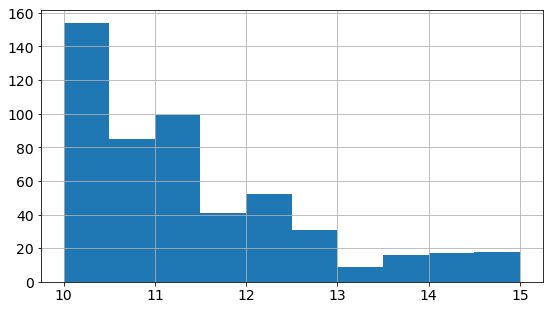

In [85]:
# Filter outliers in hspf
print(dfd.hspf.describe())
dfd.hspf.hist()

In [86]:
# Must have an HSPF of at least 10 to make list.  For now use 18 as an
# upper limit, but later that may not be high enough.
orig_ct = len(dfd)
dfd = dfd.query('hspf >= 10.0 and hspf <= 18')
print(len(dfd) - orig_ct, 'eliminated')

0 eliminated


count    522.000000
mean       2.411754
std        1.398841
min        0.750000
25%        1.382500
50%        1.970000
75%        3.007500
max        8.353000
Name: in_pwr_5F_max, dtype: float64


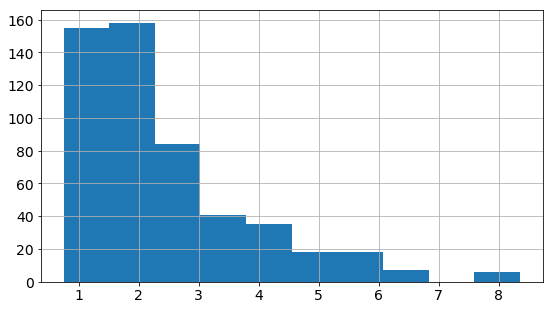

In [87]:
# Filter outliers in Input Power
print(dfd.in_pwr_5F_max.describe())
dfd.in_pwr_5F_max.hist()

In [88]:
orig_ct = len(dfd)
dfd = dfd.query('in_pwr_5F_max >= 0.75 and in_pwr_5F_max <= 10.0')
print(len(dfd) - orig_ct, 'eliminated')

0 eliminated


count      522.000000
mean     17000.989693
std       9719.061724
min       5736.000000
25%      10488.000000
50%      13600.000000
75%      20634.000000
max      57000.000000
Name: capacity_5F_max, dtype: float64


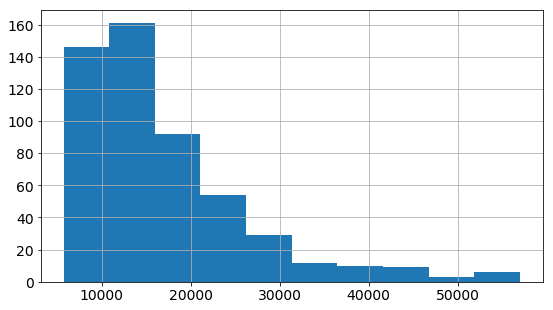

In [89]:
# Filter outliers in Max Capacity
print(dfd.capacity_5F_max.describe())
dfd.capacity_5F_max.hist()

In [90]:
orig_ct = len(dfd)
dfd = dfd.query('capacity_5F_max >= 5000. and capacity_5F_max <= 70000.')
print(len(dfd) - orig_ct, 'eliminated')

0 eliminated


count    522.000000
mean       0.405792
std        0.311007
min        0.060000
25%        0.188000
50%        0.270000
75%        0.500000
max        1.419000
Name: in_pwr_47F_min, dtype: float64


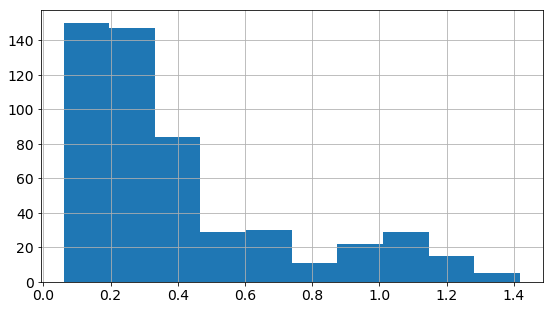

In [91]:
# Filter outliers in Min Power
print(dfd.in_pwr_47F_min.describe())
dfd.in_pwr_47F_min.hist()

In [92]:
orig_ct = len(dfd)
dfd = dfd.query('in_pwr_47F_min >= 0.05 and in_pwr_47F_min <= 2.0')
print(len(dfd) - orig_ct, 'eliminated')

0 eliminated


count    522.000000
mean       2.108058
std        0.293471
min        1.713829
25%        1.907509
50%        2.019892
75%        2.238256
max        2.937877
Name: cop_5F_max, dtype: float64


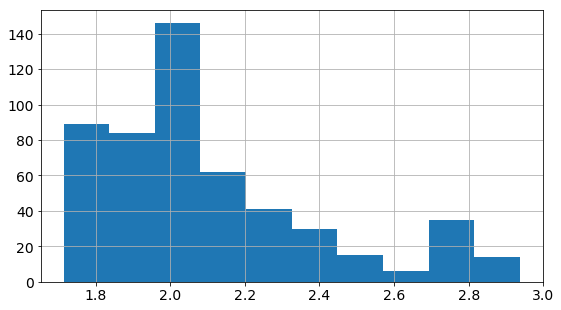

In [93]:
# Filter outliers in COP at max 5 deg F
print(dfd.cop_5F_max.describe())
dfd.cop_5F_max.hist()

In [94]:
orig_ct = len(dfd)
dfd = dfd.query('cop_5F_max >= 1.5 and cop_5F_max <= 3.5')
print(len(dfd) - orig_ct, 'eliminated')

0 eliminated


count    522.000000
mean       2.397846
std        0.351765
min        1.761915
25%        2.120000
50%        2.331349
75%        2.632947
max        3.615743
Name: cop_17F_max, dtype: float64


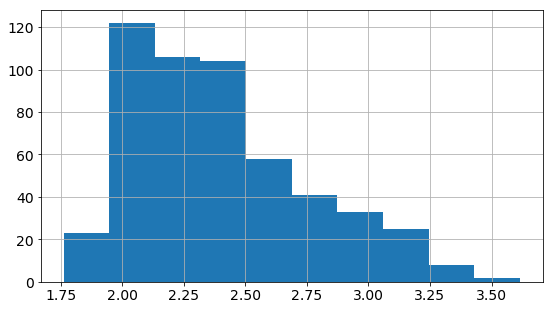

In [95]:
# Filter outliers in COP at max 17 deg F
print(dfd.cop_17F_max.describe())
dfd.cop_17F_max.hist()

In [96]:
orig_ct = len(dfd)
dfd = dfd.query('cop_17F_max >= 1.5 and cop_17F_max <= 4.0')
print(len(dfd) - orig_ct, 'eliminated')

0 eliminated


count    522.000000
mean       3.160291
std        0.464538
min        2.085976
25%        2.837130
50%        3.139500
75%        3.491341
max        4.700000
Name: cop_47F_max, dtype: float64


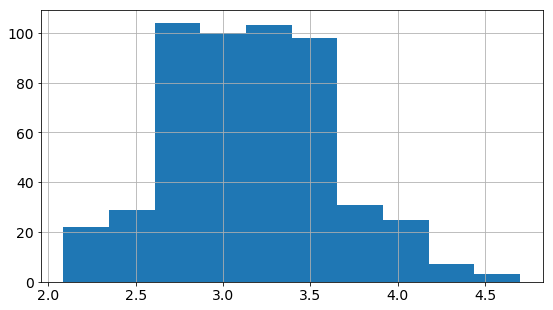

In [97]:
# Filter outliers in COP at max 47 deg F
print(dfd.cop_47F_max.describe())
dfd.cop_47F_max.hist()

In [98]:
orig_ct = len(dfd)
dfd = dfd.query('cop_47F_max >= 1.75 and cop_47F_max <= 5.0')
print(len(dfd) - orig_ct, 'eliminated')

0 eliminated


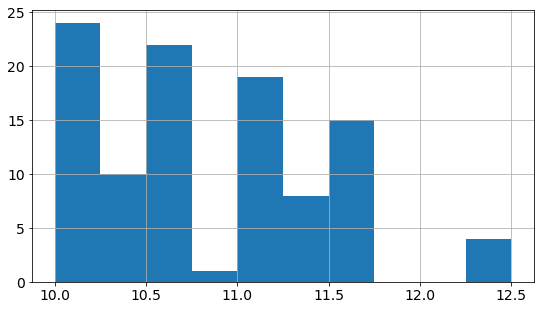

In [99]:
dfd.query("zones == 'Multi'").hspf.hist()

In [100]:
au.save_df(dfd, f'data/heat-pump/proc/hp_specs')

saving DataFrame to data/heat-pump/proc/hp_specs.pkl and .csv


In [101]:
# When convinced Raw and Processed data is good, upload to bucket.
# Upload raw heat pump spreadsheet to the bucket.
bucket.upload_dir('data/heat-pump/raw/', 'heat-pump/raw', clear_dest_dir=True)

deleting heat-pump/raw/neep_ashp_data.xlsx
deleting heat-pump/raw/neep_ashp_data_old.xlsx
uploaded data/heat-pump/raw\neep_ashp_data.xlsx with Content Type: application/vnd.openxmlformats-officedocument.spreadsheetml.sheet
uploaded data/heat-pump/raw\neep_ashp_data_old.xlsx with Content Type: application/vnd.openxmlformats-officedocument.spreadsheetml.sheet


In [102]:
bucket.upload_dir('data/heat-pump/proc/', 'heat-pump/proc', clear_dest_dir=True)

deleting heat-pump/proc/hp_specs.csv
deleting heat-pump/proc/hp_specs.pkl
uploaded data/heat-pump/proc\hp_specs.csv with Content Type: text/csv
uploaded data/heat-pump/proc\hp_specs.pkl with Content Type: application/octet-stream
